# Bias Detection Engine Demo

In [7]:
!pip install aif360
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Pytho

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# sns.set_style('white')

from aif360.sklearn.metrics import *

Load simulated recruiting data

In [2]:
# df = pd.read_excel('recruiting_simulated_data_2020_8_4_v1(1).xlsx')
df = pd.read_excel('recruiting_simulated_data_2020_8_6_v1.xlsx')
df = df.drop(columns=['black_shortlist_bias', 'black_interview_bias', 'black_offer_bias', 'black_hire_bias'])
df

,race,gender,date_application,date_shortlist,date_interview,date_offer,date_hire,date_disposition
0,White,Male,2017-03-04 00:59:49,2017-03-13 19:51:54.626,2017-03-24 20:45:05.180,NaT,NaT,2017-04-03 23:19:04.364
1,Hispanic,Female,2018-04-21 18:55:40,NaT,NaT,NaT,NaT,2018-05-02 10:00:48.166
2,White,Female,2016-06-25 18:14:13,2016-07-07 23:05:05.119,2016-07-23 16:18:22.119,NaT,NaT,2016-08-03 22:30:52.413
3,Multiple Races,NaN,2015-04-19 01:00:12,2015-05-01 07:21:36.895,NaT,NaT,NaT,2015-05-12 06:16:59.723
4,White,Female,2018-06-10 03:11:14,2018-06-19 12:45:36.700,NaT,NaT,NaT,2018-06-29 07:59:56.518
...,...,...,...,...,...,...,...,...
9995,Black,Female,2018-10-15 19:06:44,NaT,NaT,NaT,NaT,2018-10-26 08:54:37.277
9996,Multiple Races,Female,2016-05-12 19:49:45,NaT,NaT,NaT,NaT,2016-05-23 08:12:30.520
9997,White,Female,2017-08-16 00:11:44,2017-08-27 17:19:00.073,2017-09-05 20:44:46.267,NaT,NaT,2017-09-16 22:54:16.974
9998,White,Female,2017-09-11 14:09:38,2017-09-19 23:02:33.263,NaT,NaT,NaT,2017-10-03 01:06:20.815


In [3]:
df.loc[:, 'date_application':] = ~df.loc[:, 'date_application':].applymap(pd.isna)
Y = df.fillna('Other').set_index(['race', 'gender']).drop(columns=['date_disposition'])
Y

,,date_application,date_shortlist,date_interview,date_offer,date_hire
race,gender,,,,,
White,Male,True,True,True,False,False
Hispanic,Female,True,False,False,False,False
White,Female,True,True,True,False,False
Multiple Races,Other,True,True,False,False,False
White,Female,True,True,False,False,False
...,...,...,...,...,...,...
Black,Female,True,False,False,False,False
Multiple Races,Female,True,False,False,False,False
White,Female,True,True,True,False,False


In [4]:
def DI_table(prot_attr=None):
    with np.errstate(divide='ignore'):
        pct = [Y.xs(g, level=prot_attr).shape[0]/Y.shape[0] for g in Y.index.unique(prot_attr)]
        data = [[np.divide(1, disparate_impact_ratio(Y[Y[prev]][stage], prot_attr=prot_attr, priv_group=g))
                 for stage, prev in zip(Y.columns[1:], Y.columns)]
                for g in Y.index.unique(prot_attr)]
        table = pd.DataFrame(np.c_[pct, data],
                columns=['proportion of applicants'] + Y.columns[1:].tolist(),
                index=Y.index.unique(prot_attr)).sort_index()
    def colorize(di):
        # lambda x: 'color: red' if x < 0.8 or x > 1.25 else ''
        if di < 0.8:
            return 'color: red'
        elif di > 1.25:
            return 'color: blue'
        return ''
    return table.style.format('{:.3f}').format({'proportion of applicants': '{:.1%}'}
            ).bar(subset='proportion of applicants', align='zero', color='#5fba7d'
            ).applymap(colorize, subset=Y.columns[1:])

In [5]:
DI_table('race')

,proportion of applicants,date_shortlist,date_interview,date_offer,date_hire
race,,,,,
American Indian,2.1%,1.055,1.095,1.134,0.808
Asian,5.8%,1.096,1.044,0.996,1.049
Black,13.1%,0.525,0.994,0.904,0.763
Hispanic,15.8%,1.054,1.041,1.121,1.046
Multiple Races,3.1%,1.135,1.012,1.232,1.103
Native Hawaiian or Pacific Islander,1.1%,1.009,1.035,1.452,1.059
Other,3.0%,0.997,0.986,0.840,0.987
White,55.8%,1.180,0.959,0.915,1.021


Closer to 1 is better. Disparate impact < 0.8 implies bias against group, > 1.25 implies bias for group.

In [6]:
DI_table('gender')

,proportion of applicants,date_shortlist,date_interview,date_offer,date_hire
gender,,,,,
Female,47.8%,0.977,1.046,1.036,1.053
Male,48.3%,1.019,0.971,0.938,0.952
Other,4.0%,1.029,0.903,1.205,0.984


In [7]:
DI_table()

Disparate impact is simply the ratio of _selection rates_, or the proportion of applicants who move on to the next stage, between one group and all the others.

Therefore, we can look at selection rates themselves to see which groups are disadvantaged.

In [8]:
def DI_grid():
    num_stages = Y.columns.size - 1
    f, axes = plt.subplots(1, num_stages, figsize=(2+4*num_stages, 12), squeeze=True, sharey=True)
    for ax, stage, cond in zip(axes, Y.columns[1:], Y.columns):
        rates = Y[Y[cond]][stage].groupby(level=['race', 'gender']).apply(base_rate)
        sns.heatmap(rates.unstack(), annot=True, fmt='.1%', cmap='RdBu', center=base_rate(Y[Y[cond]][stage]), robust=True, cbar=False, square=True, ax=ax);
        ax.set_title(f'{stage}')#' | {cond}')
    plt.close()
    return f

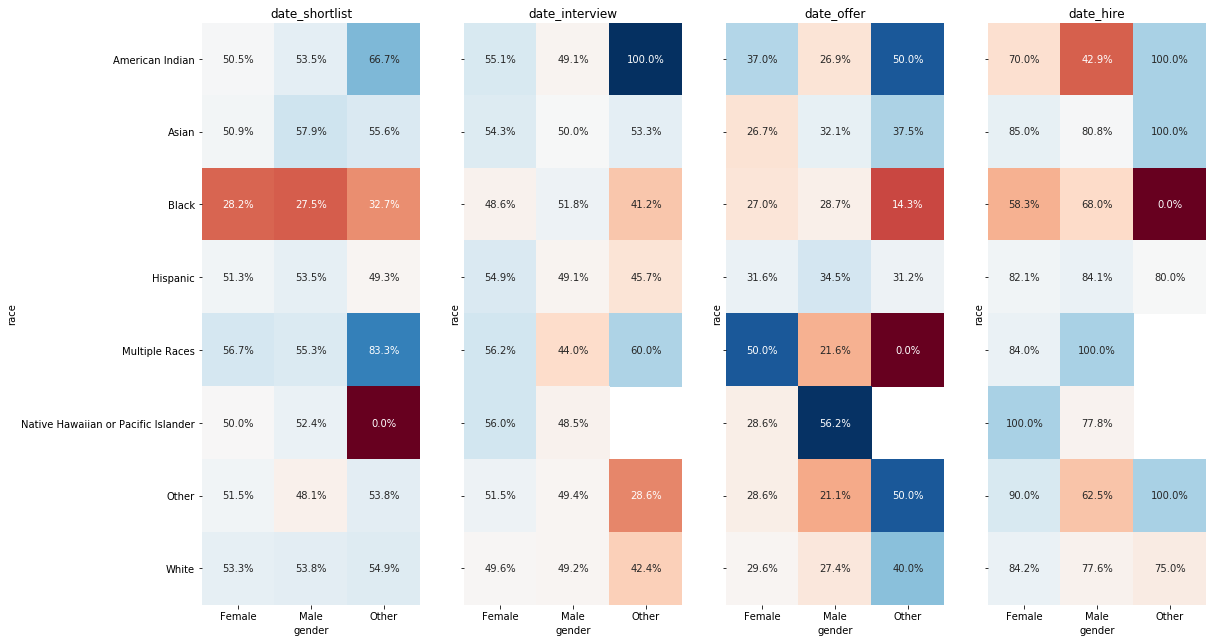

In [9]:
DI_grid()

Redder colored squares are worse than average and bluer squares are better than average. Blank squares mean there is no data.